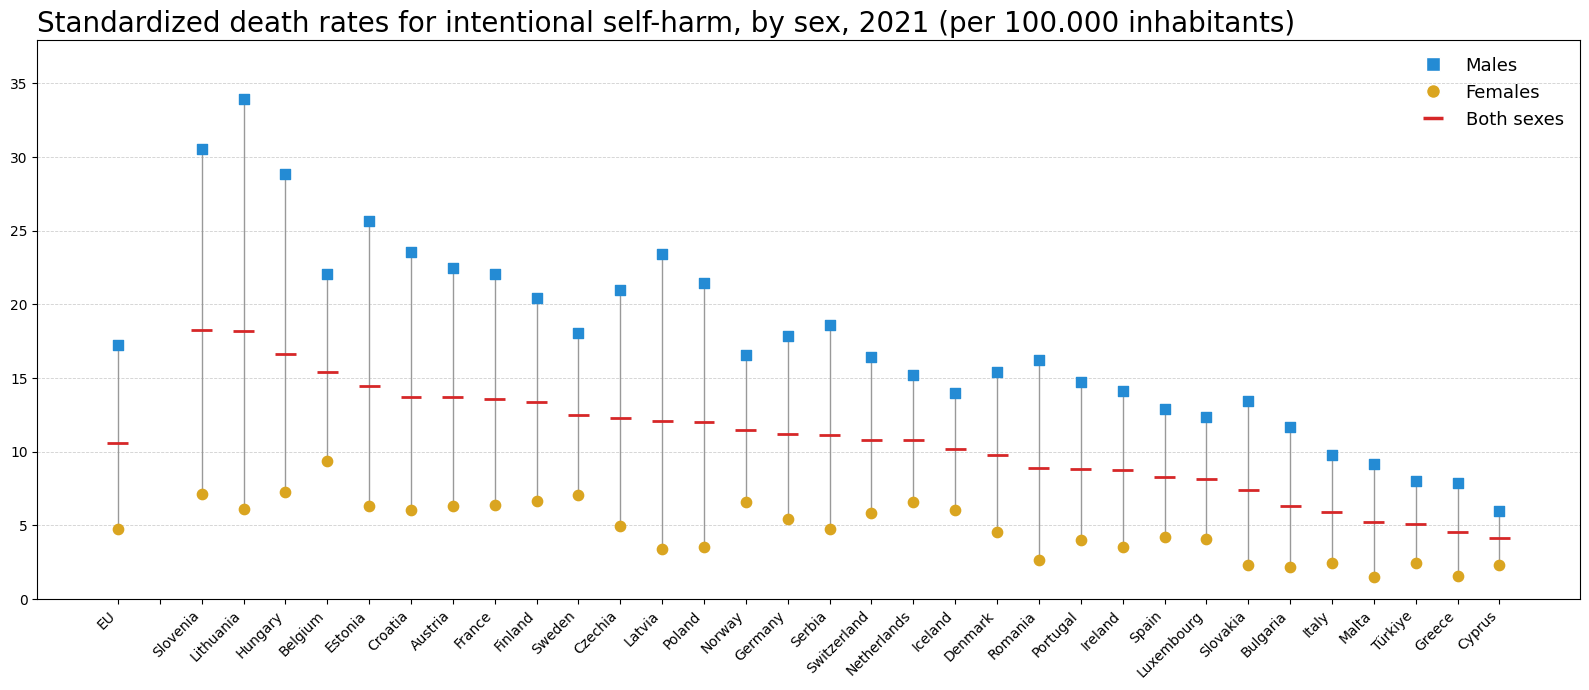

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#Carica il file
path = "Dataset\death_self harm_sex.csv"
df = pd.read_csv(path)

# Selezione e reshaping dati 
df_f = df[df['sex'].str.lower().str.contains('female')][['geo','OBS_VALUE']].rename(columns={'OBS_VALUE':'Females'})
df_m = df[df['sex'].str.lower().str.contains('male') & ~df['sex'].str.lower().str.contains('female')][['geo','OBS_VALUE']].rename(columns={'OBS_VALUE':'Males'})
df_t = df[df['sex'].str.lower().str.contains('total')][['geo','OBS_VALUE']].rename(columns={'OBS_VALUE':'Total'})

df_joined = df_f.merge(df_m, on='geo', how='inner').merge(df_t, on='geo', how='inner')
df_joined = df_joined.rename(columns={'geo':'Country'})

# numerici
for c in ['Females','Males','Total']:
    df_joined[c] = pd.to_numeric(df_joined[c], errors='coerce')

# Rinomino EU 
is_eu = df_joined['Country'].str.contains("European Union", case=False, na=False)
df_eu = df_joined[is_eu].copy()
if not df_eu.empty:
    df_eu.loc[:, 'Country'] = "EU"

df_rest = df_joined[~is_eu].copy()
df_rest = df_rest.dropna(subset=['Females','Males','Total'])
df_rest = df_rest.sort_values('Total', ascending=False)


if not df_eu.empty:
    df_plot = pd.concat([df_eu, pd.DataFrame([["", np.nan, np.nan, np.nan]],
                                             columns=df_eu.columns), df_rest],
                        ignore_index=True)
else:
    df_plot = df_rest.copy()

# Vettori per il plot
countries = df_plot['Country'].tolist()
x = np.arange(len(countries))                
mask = df_plot['Country'] != ""              

x_real = x[mask.values]                      
yM = df_plot.loc[mask, 'Males'].to_numpy()
yF = df_plot.loc[mask, 'Females'].to_numpy()
yT = df_plot.loc[mask, 'Total'].to_numpy()

# valori EU per legenda
males_eu = females_eu = total_eu = None
if "EU" in df_plot['Country'].values:
    eu_row = df_plot[df_plot['Country'] == "EU"].iloc[0]
    males_eu, females_eu, total_eu = eu_row['Males'], eu_row['Females'], eu_row['Total']

# Plot
fig, ax = plt.subplots(figsize=(16, 7))
ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)

# linee verticali tra F e M 
ax.vlines(x_real, yF, yM, colors='0.6', linewidth=1, zorder=1)

# simboli
ax.scatter(x_real, yM, marker='s', s=55, color="#248bd4", label='Males', zorder=3)
ax.scatter(x_real, yF, marker='o', s=55, color="goldenrod", label='Females', zorder=4)

# trattini rossi per Total 
ax.hlines(yT, x_real - 0.25, x_real + 0.25, colors="#d62728", linewidth=2, label='Both sexes', zorder=5)

# assi, titolo, limiti
ax.set_xticks(x)
ax.set_xticklabels(countries, rotation=45, ha='right')
ymax = np.nanmax([yM.max() if len(yM) else 0, yF.max() if len(yF) else 0, yT.max() if len(yT) else 0])
ax.set_ylim(0, ymax + 4)
ax.set_ylabel('')
ax.set_title("Standardized death rates for intentional self-harm, by sex, 2021 (per 100.000 inhabitants)",
             fontsize=20, loc='left')

# legenda con simboli coerenti
legend_elems = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor="#248bd4", markersize=10,
           label='Males'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='goldenrod', markersize=10,
           label='Females'),
    Line2D([0], [0], color='#d62728', marker='_', markersize=14, markeredgewidth=2.5,
           linestyle='None', label='Both sexes')
]
ax.legend(handles=legend_elems, loc='upper right', frameon=False, fontsize=13)

plt.tight_layout()
plt.show()